In [1]:
%load_ext autoreload
%autoreload 2
import datetime
import os, sys
import numpy as np
import matplotlib.pyplot as plt

import casadi as cas

##### For viewing the videos in Jupyter Notebook
import io
import base64
from IPython.display import HTML

# from ..</src> import car_plotting
# from .import src.car_plotting
PROJECT_PATH = '/home/nbuckman/Dropbox (MIT)/DRL/2020_01_cooperative_mpc/mpc-multiple-vehicles/'
sys.path.append(PROJECT_PATH)
import src.MPC_Casadi as mpc
import src.car_plotting as cplot
import src.TrafficWorld as tw
np.set_printoptions(precision=2)
%matplotlib inline

# Vehicle Dynamics $\frac{d}{dt} \vec{x} = f(\vec{x}, \vec{u})$

In [2]:
T = 10 #numbr of time horizons
dt = 0.1
N = int(T/dt) #Number of control intervals

In [3]:
s = cas.MX.sym('s')
xd = s
yd = 0
phid = 0
des_traj = cas.vertcat(xd, yd, phid)
fd = cas.Function('fd',[s],[des_traj],['s'],['des_traj'])

In [4]:
world = tw.TrafficWorld(2, 0, 10)

#Globally true information

# initial_speed = 6.7 
initial_speed = 20 * 0.447 # m/s

lane_1_centerline = world.get_lane_centerline_y(1)
# Initial Conditions


In [5]:
xd2 = s
yd2 = lane_1_centerline
phid = 0
des_traj2 = cas.vertcat(xd2, yd2, phid)
fd2 = cas.Function('fd',[s],[des_traj2],['s'],['des_traj2'])

## IBR from Beginning

### Solve it centrally just to warm start the solution

In [6]:
x1_MPC = mpc.MPC(dt)
x2_MPC = mpc.MPC(dt)
amb_MPC = mpc.MPC(dt)

x1_MPC.theta_iamb = np.pi/4.0
x2_MPC.theta_iamb = np.pi/4.0
amb_MPC.theta_iamb = 0


x1_MPC.k_final = 1.0
x2_MPC.k_final = 1.0
amb_MPC.k_final = 1.0


x1_MPC.k_s = -1.0
x2_MPC.k_s = -1.0

amb_MPC.theta_iamb = 0.0
amb_MPC.k_u_v = 0.10
# amb_MPC.k_u_change = 1.0
amb_MPC.k_s = -1.0
amb_MPC.max_v = 40 * 0.447 # m/s
amb_MPC.max_X_dev = 5.0


x2_MPC.fd = fd
amb_MPC.fd = fd
x1_MPC.fd = fd2


# #### THIS SHOULD BE REPLACED
# x1_MPC.min_y = -1.1 * world.lane_width
# x2_MPC.min_y = -1.1 * world.lane_width
# amb_MPC.min_y = -1.1 * world.lane_width



min_dist = 2 * (2 * (x1_MPC.L/2.0)**2)**.5

x0 = np.array([1.5*min_dist, lane_1_centerline, 0, 0, initial_speed, 0]).T
x0_2 = np.array([1.5*min_dist, 0, 0.0, 0, initial_speed, 0]).T
x0_amb = np.array([0, 0.0, 0, 0, 1.1 * initial_speed , 0]).T

In [7]:
optional_suffix = "_real_dim_CA"
subdir_name = datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + optional_suffix
folder = "results/" + subdir_name + "/"
os.makedirs(folder)
os.makedirs(folder+"imgs/")
os.makedirs(folder+"data/")

print(folder)

results/20200223-210028_real_dim_CA/


In [ ]:
ibr_sub_it=1
u1 = np.zeros((2,N))
u2 = np.zeros((2,N))

In [ ]:
n_total_round = 10
for n_round in range(n_total_round):
    brA = mpc.IterativeBestResponseMPC(amb_MPC, x1_MPC, x2_MPC)
    brA.generate_optimization(N, fd, T, x0_amb, x0, x0_2,  5, slack=True)
    brA.solve(u1, u2)
    print("A", brA.solution.value(brA.car1MPC.total_cost()))
    xamb, uamb, xamb_des, x1, u1, x1_des, x2, u2, x2_des = brA.get_solution()
    brA.save_state(folder + "data/"+'%03d'%ibr_sub_it + "_a", x1, u1, x1_des, x2, u2, x2_des, xamb, uamb, xamb_des)
    ibr_sub_it+=1

    br2 = mpc.IterativeBestResponseMPC(x2_MPC, x1_MPC, amb_MPC )
    br2.generate_optimization(N, fd, T, x0_2, x0, x0_amb, 2, slack=True)
    br2.solve(u1, uamb)
    x2, u2, x2_des, x1, u1, x1_des, xamb, uamb, xamb_des = br2.get_solution()
    print(br2.solution.value(br2.slack_cost))
    print("2", br2.solution.value(br2.car1MPC.total_cost()))
    br2.save_state(folder + "data/" + '%03d'%ibr_sub_it + "_2", x1, u1, x1_des, x2, u2, x2_des, xamb, uamb, xamb_des)
    ibr_sub_it+=1

    br1 = mpc.IterativeBestResponseMPC(x1_MPC, x2_MPC, amb_MPC)
    br1.generate_optimization(N, fd, T,  x0, x0_2, x0_amb, 2, slack=True)
    br1.solve(u2, uamb)
    x1, u1, x1_des, x2, u2, x2_des, xamb, uamb, xamb_des = br1.get_solution()
    print(br1.solution.value(br1.slack_cost))
    print("1", br1.solution.value(br1.car1MPC.total_cost()))
    br1.save_state(folder + "data/" + '%03d'%ibr_sub_it + "_1", x1, u1, x1_des, x2, u2, x2_des, xamb, uamb, xamb_des)
    ibr_sub_it+=1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     8430
Number of nonzeros in inequality constraint Jacobian.:     7371
Number of nonzeros in Lagrangian Hessian.............:     7555

Total number of variables............................:     4947
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     2727
Total number of inequality constraints...............:     2321
        inequality constraints with only lower bounds:      808
   inequality constraints with lower and upper bounds:      604
        inequality constraints with only upper bounds:      808

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

In [14]:
subdir_name = "20200223-210028_real_dim_CA"
folder = "results/" + subdir_name + "/"
br2 = mpc.IterativeBestResponseMPC(x1_MPC, x2_MPC, amb_MPC )
br2.generate_optimization(N, fd, T, x0, x0_2, x0_amb, 2, slack=True)
ibr_sub_it = 15
# for ibr_sub_it in range(1, 40):
if (ibr_sub_it % 3) == 0:
    response_car = "1"
elif (ibr_sub_it % 3) == 1:
    response_car = "a"
else:
    response_car = "2"
ibr_prefix = '%03d'%ibr_sub_it + "_" + response_car
x1, u1, x1_des, x2, u2, x2_des, xamb, uamb, xamb_des = br2.load_state(folder + "data/" + ibr_prefix)
CIRCLES = False
cplot.plot_cars_circles(world, x1, x2, xamb, folder, x1_MPC, x2_MPC, amb_MPC, brA)


In [15]:
if CIRCLES:
    vid_fname = folder + "vids/" + 'circle_' + subdir_name + ibr_prefix + '.mp4'
else:
    vid_fname = folder + "vids/" + 'car_' + subdir_name + ibr_prefix +'.mp4'    
if os.path.exists(vid_fname):
    os.remove(vid_fname)
cmd = 'ffmpeg -r 16 -f image2 -i {}imgs/%03d.png -vcodec libx264 -crf 25  -pix_fmt yuv420p {}'.format(folder, vid_fname)
os.system(cmd)
print('Saving video to: {}'.format(vid_fname))

Saving video to: results/20200223-210028_real_dim_CA/vids/car_20200223-210028_real_dim_CA015_1.mp4


In [ ]:
if (ibr_sub_it % 3) == 0:
        response_car = "1"
    elif (ibr_sub_it % 3) == 1:
        response_car = "a"
    else:
        response_car = "2"
    ibr_prefix =  '%02d'%ibr_sub_it + "_" + response_car
    x1, u1, x1_des, x2, u2, x2_des, xamb, uamb, xamb_des = br2.load_state(folder + ibr_prefix)
    CIRCLES = False
    cplot.plot_cars_multiproc(x1, x2, xamb, folder, x1_des, x2_des, xamb_des, CIRCLES, min_dist)
    if CIRCLES:
        vid_fname = folder + subdir_name + 'circle_' + ibr_prefix3 + '.mp4'
    else:
        vid_fname = folder + subdir_name + 'car_' + ibr_prefix +'.mp4'    
    if os.path.exists(vid_fname):
        os.remove(vid_fname)
    cmd = 'ffmpeg -r 16 -f image2 -i {}imgs/%03d.png -vcodec libx264 -crf 25  -pix_fmt yuv420p {}'.format(folder, vid_fname)
    os.system(cmd)
    print('Saving video to: {}'.format(vid_fname))

In [35]:
x1_plot, x2_plot, xamb_plot, folder, x1_desired, x2_desired, xamb_desired, CIRCLES, min_dist = x1, x2, xamb, folder, x1_des, x2_des, xamb_des, False, min_dist
SLIDING_WINDOW = False
N = x1_plot.shape[1]
max_xplots =     max(np.hstack((x1_plot[0,:],x2_plot[0,:],xamb_plot[0,:]))) + 2
min_xplots = min(np.hstack((x1_plot[0,:],x2_plot[0,:],xamb_plot[0,:]))) - 2
max_yplots = max(np.hstack((x1_plot[1,:],x2_plot[1,:],xamb_plot[1,:])))
xmin, xmax = min_xplots, max_xplots
ymax = max_yplots + 0.5
ymin = min(np.hstack((x1_plot[1,:],x2_plot[1,:],xamb_plot[1,:]))) - .5 # Based on ymin that we give to MPC
width = max_xplots/2.0
axlim_minx = min_xplots
axlim_maxx = max_xplots
if not SLIDING_WINDOW:
    axlim_minx = xmin
    axlim_maxx = xmax

for k in range(N):
    print(k)
    cplot.plot_three_cars( k, ymax, ymin, axlim_maxx, axlim_minx, x1_plot, x2_plot, xamb_plot, SLIDING_WINDOW, width, min_dist, CIRCLES, x1_desired, x2_desired, xamb_desired, folder, world)     


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0
axlim -10.0 10.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


al -10.0 10.0
al2 -10.0 10.0
al2 -10.0 10.0
1
axlim -9.018602246503917 10.981397753496083


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


al -9.018602246503917 10.981397753496083
al2 -9.018602246503917 10.981397753496083
al2 -9.018602246503917 10.981397753496083
2
axlim -8.041257922570793 11.958742077429207


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


al -8.041257922570793 11.958742077429207
al2 -8.041257922570793 11.958742077429207
al2 -8.041257922570793 11.958742077429207
3
axlim -7.0682104952178095 12.931789504782191


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


al -7.0682104952178095 12.931789504782191
al2 -7.0682104952178095 12.931789504782191
al2 -7.0682104952178095 12.931789504782191
4
axlim -6.099834253309282 13.900165746690718


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


al -6.099834253309282 13.900165746690718
al2 -6.099834253309282 13.900165746690718
al2 -6.099834253309282 13.900165746690718
5
axlim -5.134566126420968 14.865433873579033


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


al -5.134566126420968 14.865433873579033
al2 -5.134566126420968 14.865433873579033
al2 -5.134566126420968 14.865433873579033
6
axlim -4.168029404595548 15.831970595404453


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


al -4.168029404595548 15.831970595404453
al2 -4.168029404595548 15.831970595404453
al2 -4.168029404595548 15.831970595404453
7
axlim -3.1972702176073238 16.802729782392674


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


al -3.1972702176073238 16.802729782392674
al2 -3.1972702176073238 16.802729782392674
al2 -3.1972702176073238 16.802729782392674
8
axlim -2.221882227173623 17.778117772826377


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


al -2.221882227173623 17.778117772826377
al2 -2.221882227173623 17.778117772826377
al2 -2.221882227173623 17.778117772826377
9
axlim -1.2417638626667813 18.75823613733322


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


al -1.2417638626667813 18.75823613733322
al2 -1.2417638626667813 18.75823613733322
al2 -1.2417638626667813 18.75823613733322
10
axlim -0.2573464066135145 19.742653593386486


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


al -0.2573464066135145 19.742653593386486
al2 -0.2573464066135145 19.742653593386486
al2 -0.2573464066135145 19.742653593386486
11
axlim 0.7301672865598601 20.730167286559862


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


al 0.7301672865598601 20.730167286559862
al2 0.7301672865598601 20.730167286559862
al2 0.7301672865598601 20.730167286559862
12
axlim 1.7187391094400706 21.718739109440072


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


al 1.7187391094400706 21.718739109440072
al2 1.7187391094400706 21.718739109440072
al2 1.7187391094400706 21.718739109440072
13
axlim 2.706510422012048 22.706510422012048


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


al 2.706510422012048 22.706510422012048
al2 2.706510422012048 22.706510422012048
al2 2.706510422012048 22.706510422012048
14
axlim 3.692809212089619 23.69280921208962


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


al 3.692809212089619 23.69280921208962
al2 3.692809212089619 23.69280921208962
al2 3.692809212089619 23.69280921208962
15
axlim 4.6779859315784815 24.677985931578483


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


al 4.6779859315784815 24.677985931578483
al2 4.6779859315784815 24.677985931578483
al2 4.6779859315784815 24.677985931578483
16
axlim 5.663129940575393 25.663129940575395


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


al 5.663129940575393 25.663129940575395
al2 5.663129940575393 25.663129940575395
al2 5.663129940575393 25.663129940575395
17
axlim 6.649857922669735 26.649857922669735


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


al 6.649857922669735 26.649857922669735
al2 6.649857922669735 26.649857922669735
al2 6.649857922669735 26.649857922669735
18
axlim 7.640095786479698 27.640095786479698


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


al 7.640095786479698 27.640095786479698
al2 7.640095786479698 27.640095786479698
al2 7.640095786479698 27.640095786479698
19
axlim 8.635852631996887 28.635852631996887


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


al 8.635852631996887 28.635852631996887
al2 8.635852631996887 28.635852631996887
al2 8.635852631996887 28.635852631996887
20
axlim 9.638984474755386 29.638984474755386


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


al 9.638984474755386 29.638984474755386
al2 9.638984474755386 29.638984474755386
al2 9.638984474755386 29.638984474755386
21
axlim 10.650945115602177 30.650945115602177


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


al 10.650945115602177 30.650945115602177
al2 10.650945115602177 30.650945115602177
al2 10.650945115602177 30.650945115602177
22
axlim 11.672521899124948 31.67252189912495


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


al 11.672521899124948 31.67252189912495
al2 11.672521899124948 31.67252189912495
al2 11.672521899124948 31.67252189912495
23
axlim 12.703522970747265 32.703522970747265


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


al 12.703522970747265 32.703522970747265
al2 12.703522970747265 32.703522970747265
al2 12.703522970747265 32.703522970747265
24
axlim 13.742454229661089 33.74245422966109


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


al 13.742454229661089 33.74245422966109
al2 13.742454229661089 33.74245422966109
al2 13.742454229661089 33.74245422966109
25
axlim 14.786818901244406 34.7868189012444


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


al 14.786818901244406 34.7868189012444
al2 14.786818901244406 34.7868189012444
al2 14.786818901244406 34.7868189012444
26
axlim 15.834134673419097 35.8341346734191


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


al 15.834134673419097 35.8341346734191
al2 15.834134673419097 35.8341346734191
al2 15.834134673419097 35.8341346734191
27
axlim 16.88260318321065 36.88260318321065


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


al 16.88260318321065 36.88260318321065
al2 16.88260318321065 36.88260318321065
al2 16.88260318321065 36.88260318321065
28
axlim 17.931294102753753 37.93129410275375


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


al 17.931294102753753 37.93129410275375
al2 17.931294102753753 37.93129410275375
al2 17.931294102753753 37.93129410275375
29
axlim 18.98005206349281 38.980052063492806


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


al 18.98005206349281 38.980052063492806
al2 18.98005206349281 38.980052063492806
al2 18.98005206349281 38.980052063492806
30
axlim 20.029357052460526 40.029357052460526


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


al 20.029357052460526 40.029357052460526
al2 20.029357052460526 40.029357052460526
al2 20.029357052460526 40.029357052460526
31
axlim 21.080289133116505 41.08028913311651


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


al 21.080289133116505 41.08028913311651
al2 21.080289133116505 41.08028913311651
al2 21.080289133116505 41.08028913311651
32
axlim 22.134478916221752 42.13447891622175


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


al 22.134478916221752 42.13447891622175
al2 22.134478916221752 42.13447891622175
al2 22.134478916221752 42.13447891622175
33
axlim 23.193705292350494 43.193705292350494


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


al 23.193705292350494 43.193705292350494
al2 23.193705292350494 43.193705292350494
al2 23.193705292350494 43.193705292350494
34
axlim 24.25941589745178 44.25941589745178


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


al 24.25941589745178 44.25941589745178
al2 24.25941589745178 44.25941589745178
al2 24.25941589745178 44.25941589745178
35
axlim 25.33239149497033 45.33239149497033


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


al 25.33239149497033 45.33239149497033
al2 25.33239149497033 45.33239149497033
al2 25.33239149497033 45.33239149497033
36
axlim 26.412715857373755 46.412715857373755


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


al 26.412715857373755 46.412715857373755
al2 26.412715857373755 46.412715857373755
al2 26.412715857373755 46.412715857373755
37
axlim 27.499957390684173 47.49995739068417


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


al 27.499957390684173 47.49995739068417
al2 27.499957390684173 47.49995739068417
al2 27.499957390684173 47.49995739068417
38
axlim 28.59342330405999 48.59342330405999


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


al 28.59342330405999 48.59342330405999
al2 28.59342330405999 48.59342330405999
al2 28.59342330405999 48.59342330405999
39
axlim 29.692385301946494 49.692385301946494


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


al 29.692385301946494 49.692385301946494
al2 29.692385301946494 49.692385301946494
al2 29.692385301946494 49.692385301946494
40
axlim 30.79622648234764 50.79622648234764


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


al 30.79622648234764 50.79622648234764
al2 30.79622648234764 50.79622648234764
al2 30.79622648234764 50.79622648234764
41
axlim 31.904503616706833 51.90450361670683


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


al 31.904503616706833 51.90450361670683
al2 31.904503616706833 51.90450361670683
al2 31.904503616706833 51.90450361670683
42
axlim 33.01694536695562 53.01694536695562


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


al 33.01694536695562 53.01694536695562
al2 33.01694536695562 53.01694536695562
al2 33.01694536695562 53.01694536695562
43
axlim 34.133415258599584 54.133415258599584


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


al 34.133415258599584 54.133415258599584
al2 34.133415258599584 54.133415258599584
al2 34.133415258599584 54.133415258599584
44
axlim 35.25386437185535 55.25386437185535


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


al 35.25386437185535 55.25386437185535
al2 35.25386437185535 55.25386437185535
al2 35.25386437185535 55.25386437185535
45
axlim 36.37828968585117 56.37828968585117


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


al 36.37828968585117 56.37828968585117
al2 36.37828968585117 56.37828968585117
al2 36.37828968585117 56.37828968585117
46
axlim 37.50670494341196 57.50670494341196


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


al 37.50670494341196 57.50670494341196
al2 37.50670494341196 57.50670494341196
al2 37.50670494341196 57.50670494341196
47
axlim 38.63912439636935 58.63912439636935


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


al 38.63912439636935 58.63912439636935
al2 38.63912439636935 58.63912439636935
al2 38.63912439636935 58.63912439636935
48
axlim 39.7755563996 59.7755563996


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


al 39.7755563996 59.7755563996
al2 39.7755563996 59.7755563996
al2 39.7755563996 59.7755563996
49
axlim 40.91600292898481 60.91600292898481


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


al 40.91600292898481 60.91600292898481
al2 40.91600292898481 60.91600292898481
al2 40.91600292898481 60.91600292898481
50
axlim 42.06046168951874 62.06046168951874


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


al 42.06046168951874 62.06046168951874
al2 42.06046168951874 62.06046168951874
al2 42.06046168951874 62.06046168951874
51
axlim 43.208928637223465 63.208928637223465


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


al 43.208928637223465 63.208928637223465
al2 43.208928637223465 63.208928637223465
al2 43.208928637223465 63.208928637223465
52
axlim 44.36139985504523 64.36139985504522


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


al 44.36139985504523 64.36139985504522
al2 44.36139985504523 64.36139985504522
al2 44.36139985504523 64.36139985504522
53
axlim 45.51787251616411 65.51787251616412


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


al 45.51787251616411 65.51787251616412
al2 45.51787251616411 65.51787251616412
al2 45.51787251616411 65.51787251616412
54
axlim 46.6783450937757 66.6783450937757


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


al 46.6783450937757 66.6783450937757
al2 46.6783450937757 66.6783450937757
al2 46.6783450937757 66.6783450937757
55
axlim 47.84281711721894 67.84281711721894


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


al 47.84281711721894 67.84281711721894
al2 47.84281711721894 67.84281711721894
al2 47.84281711721894 67.84281711721894
56
axlim 49.01128874992779 69.01128874992779


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


al 49.01128874992779 69.01128874992779
al2 49.01128874992779 69.01128874992779
al2 49.01128874992779 69.01128874992779
57
axlim 50.18376037756766 70.18376037756767


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


al 50.18376037756766 70.18376037756767
al2 50.18376037756766 70.18376037756767
al2 50.18376037756766 70.18376037756767
58
axlim 51.360232309091835 71.36023230909183


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


al 51.360232309091835 71.36023230909183
al2 51.360232309091835 71.36023230909183
al2 51.360232309091835 71.36023230909183
59
axlim 52.540704636612965 72.54070463661296


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


al 52.540704636612965 72.54070463661296
al2 52.540704636612965 72.54070463661296
al2 52.540704636612965 72.54070463661296
60
axlim 53.72517726302835 73.72517726302834


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


al 53.72517726302835 73.72517726302834
al2 53.72517726302835 73.72517726302834
al2 53.72517726302835 73.72517726302834
61
axlim 54.91365002938437 74.91365002938437


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


al 54.91365002938437 74.91365002938437
al2 54.91365002938437 74.91365002938437
al2 54.91365002938437 74.91365002938437
62
axlim 56.10612281183681 76.10612281183681


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


al 56.10612281183681 76.10612281183681
al2 56.10612281183681 76.10612281183681
al2 56.10612281183681 76.10612281183681
63
axlim 57.3025955521647 77.3025955521647


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


al 57.3025955521647 77.3025955521647
al2 57.3025955521647 77.3025955521647
al2 57.3025955521647 77.3025955521647
64
axlim 58.503068245621236 78.50306824562124


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


al 58.503068245621236 78.50306824562124
al2 58.503068245621236 78.50306824562124
al2 58.503068245621236 78.50306824562124
65
axlim 59.70754091464542 79.70754091464542


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


al 59.70754091464542 79.70754091464542
al2 59.70754091464542 79.70754091464542
al2 59.70754091464542 79.70754091464542
66
axlim 60.916013586168816 80.91601358616882


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


al 60.916013586168816 80.91601358616882
al2 60.916013586168816 80.91601358616882
al2 60.916013586168816 80.91601358616882
67
axlim 62.12848627899736 82.12848627899736


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


al 62.12848627899736 82.12848627899736
al2 62.12848627899736 82.12848627899736
al2 62.12848627899736 82.12848627899736
68
axlim 63.34495900051034 83.34495900051034


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


al 63.34495900051034 83.34495900051034
al2 63.34495900051034 83.34495900051034
al2 63.34495900051034 83.34495900051034
69
axlim 64.56543174899583 84.56543174899583


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


al 64.56543174899583 84.56543174899583
al2 64.56543174899583 84.56543174899583
al2 64.56543174899583 84.56543174899583
70
axlim 65.78990451792596 85.78990451792596


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


al 65.78990451792596 85.78990451792596
al2 65.78990451792596 85.78990451792596
al2 65.78990451792596 85.78990451792596
71
axlim 67.01837729975304 87.01837729975304


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


al 67.01837729975304 87.01837729975304
al2 67.01837729975304 87.01837729975304
al2 67.01837729975304 87.01837729975304
72
axlim 68.25085008822765 88.25085008822765


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


al 68.25085008822765 88.25085008822765
al2 68.25085008822765 88.25085008822765
al2 68.25085008822765 88.25085008822765
73
axlim 69.48732287924271 89.48732287924271


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


al 69.48732287924271 89.48732287924271
al2 69.48732287924271 89.48732287924271
al2 69.48732287924271 89.48732287924271
74


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


axlim 70.72779567068078 90.72779567068078


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


al 70.72779567068078 90.72779567068078
al2 70.72779567068078 90.72779567068078
al2 70.72779567068078 90.72779567068078
75
axlim 71.97226846181144 91.97226846181144


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


al 71.97226846181144 91.97226846181144
al2 71.97226846181144 91.97226846181144
al2 71.97226846181144 91.97226846181144
76
axlim 73.2207412526433 93.2207412526433


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


al 73.2207412526433 93.2207412526433
al2 73.2207412526433 93.2207412526433
al2 73.2207412526433 93.2207412526433
77
axlim 74.47321404343886 94.47321404343886


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


al 74.47321404343886 94.47321404343886
al2 74.47321404343886 94.47321404343886
al2 74.47321404343886 94.47321404343886
78
axlim 75.72968683444267 95.72968683444267


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


al 75.72968683444267 95.72968683444267
al2 75.72968683444267 95.72968683444267
al2 75.72968683444267 95.72968683444267
79
axlim 76.99015962578255 96.99015962578255


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


al 76.99015962578255 96.99015962578255
al2 76.99015962578255 96.99015962578255
al2 76.99015962578255 96.99015962578255
80
axlim 78.25463241747387 98.25463241747387


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


al 78.25463241747387 98.25463241747387
al2 78.25463241747387 98.25463241747387
al2 78.25463241747387 98.25463241747387
81
axlim 79.52310520946483 99.52310520946483


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


al 79.52310520946483 99.52310520946483
al2 79.52310520946483 99.52310520946483
al2 79.52310520946483 99.52310520946483
82
axlim 80.79557800168267 100.79557800168267


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


al 80.79557800168267 100.79557800168267
al2 80.79557800168267 100.79557800168267
al2 80.79557800168267 100.79557800168267
83
axlim 82.07205079406393 102.07205079406393


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


al 82.07205079406393 102.07205079406393
al2 82.07205079406393 102.07205079406393
al2 82.07205079406393 102.07205079406393
84
axlim 83.35252358656655 103.35252358656655


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


al 83.35252358656655 103.35252358656655
al2 83.35252358656655 103.35252358656655
al2 83.35252358656655 103.35252358656655
85
axlim 84.6369963791694 104.6369963791694


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


al 84.6369963791694 104.6369963791694
al2 84.6369963791694 104.6369963791694
al2 84.6369963791694 104.6369963791694
86
axlim 85.92546917186608 105.92546917186608


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


al 85.92546917186608 105.92546917186608
al2 85.92546917186608 105.92546917186608
al2 85.92546917186608 105.92546917186608
87
axlim 87.21794196465765 107.21794196465765


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


al 87.21794196465765 107.21794196465765
al2 87.21794196465765 107.21794196465765
al2 87.21794196465765 107.21794196465765
88
axlim 88.51441475754739 108.51441475754739


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


al 88.51441475754739 108.51441475754739
al2 88.51441475754739 108.51441475754739
al2 88.51441475754739 108.51441475754739
89
axlim 89.81488755053799 109.81488755053799


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


al 89.81488755053799 109.81488755053799
al2 89.81488755053799 109.81488755053799
al2 89.81488755053799 109.81488755053799
90
axlim 91.11936034363065 111.11936034363065


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


al 91.11936034363065 111.11936034363065
al2 91.11936034363065 111.11936034363065
al2 91.11936034363065 111.11936034363065
91
axlim 92.42783313682523 112.42783313682523


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


al 92.42783313682523 112.42783313682523
al2 92.42783313682523 112.42783313682523
al2 92.42783313682523 112.42783313682523
92
axlim 93.74030593012085 113.74030593012085


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


al 93.74030593012085 113.74030593012085
al2 93.74030593012085 113.74030593012085
al2 93.74030593012085 113.74030593012085
93
axlim 95.0567787235165 115.0567787235165


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


al 95.0567787235165 115.0567787235165
al2 95.0567787235165 115.0567787235165
al2 95.0567787235165 115.0567787235165
94
axlim 96.37725151701123 116.37725151701123


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


al 96.37725151701123 116.37725151701123
al2 96.37725151701123 116.37725151701123
al2 96.37725151701123 116.37725151701123
95
axlim 97.70172431060428 117.70172431060428


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


al 97.70172431060428 117.70172431060428
al2 97.70172431060428 117.70172431060428
al2 97.70172431060428 117.70172431060428
96
axlim 99.03019710429504 119.03019710429504


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


al 99.03019710429504 119.03019710429504
al2 99.03019710429504 119.03019710429504
al2 99.03019710429504 119.03019710429504
97
axlim 100.36266989808284 120.36266989808284


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


al 100.36266989808284 120.36266989808284
al2 100.36266989808284 120.36266989808284
al2 100.36266989808284 120.36266989808284
98
axlim 101.6991426919667 121.6991426919667


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


al 101.6991426919667 121.6991426919667
al2 101.6991426919667 121.6991426919667
al2 101.6991426919667 121.6991426919667
99


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


axlim 103.03961548594445 123.03961548594445


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


al 103.03961548594445 123.03961548594445
al2 103.03961548594445 123.03961548594445
al2 103.03961548594445 123.03961548594445
100
axlim 104.3840882800066 124.3840882800066


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


al 104.3840882800066 124.3840882800066
al2 104.3840882800066 124.3840882800066
al2 104.3840882800066 124.3840882800066


In [16]:
# CIRCLES = False
# cplot.plot_cars_multiproc(x1, x2, xamb, folder, x1_des, x2_des, xamb_des, CIRCLES, min_dist)
if CIRCLES:
    vid_fname = folder + subdir_name + 'circle_' + ibr_prefix3 + '.mp4'
else:
    vid_fname = folder + subdir_name + 'car_grass.mp4'    
if os.path.exists(vid_fname):
    os.remove(vid_fname)
cmd = 'ffmpeg -r 16 -f image2 -i {}imgs/%03d.png -vcodec libx264 -crf 25  -pix_fmt yuv420p {}'.format(folder, vid_fname)
os.system(cmd)
print('Saving video to: {}'.format(vid_fname))

Saving video to: results/20200221-104503_ibr_coop_50rds/20200221-104503_ibr_coop_50rdscar_grass.mp4


## Why is agent one doing weird things?

In [12]:
br2 = mpc.IterativeBestResponseMPC(x1_MPC, x2_MPC, amb_MPC )
br2.generate_optimization(N, min_dist, fd, T, x0_2, x0, x0_amb, 2, slack=True)

for ibr_sub_it in range(4, 5):
    if (ibr_sub_it % 3) == 0:
        response_car = "1"
    elif (ibr_sub_it % 3) == 1:
        response_car = "a"
    else:
        response_car = "2"
    ibr_prefix =  '%02d'%ibr_sub_it + "_" + response_car
    x1, u1, x1_des, x2, u2, x2_des, xamb, uamb, xamb_des = br2.load_state(folder + ibr_prefix)
    CIRCLES = False
    cplot.plot_cars_multiproc(x1, x2, xamb, folder, x1_des, x2_des, xamb_des, CIRCLES, min_dist)
    if CIRCLES:
        vid_fname = folder + subdir_name + 'circle_' + ibr_prefix3 + '.mp4'
    else:
        vid_fname = folder + subdir_name + 'car_' + ibr_prefix +'.mp4'    
    if os.path.exists(vid_fname):
        os.remove(vid_fname)
    cmd = 'ffmpeg -r 16 -f image2 -i {}imgs/%03d.png -vcodec libx264 -crf 25  -pix_fmt yuv420p {}'.format(folder, vid_fname)
    os.system(cmd)
    print('Saving video to: {}'.format(vid_fname))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Saving video to: results/20200219-164253_ibr_penalize_finalcosts/20200219-164253_ibr_penalize_finalcostscar_04_a.mp4


## Studying Agent's Iteration

In [ ]:
optional_suffix = "_ibr_penalize_finalcosts"
subdir_name = "20200219-164253_ibr_penalize_finalcosts"
folder = "results/" + subdir_name + "/"

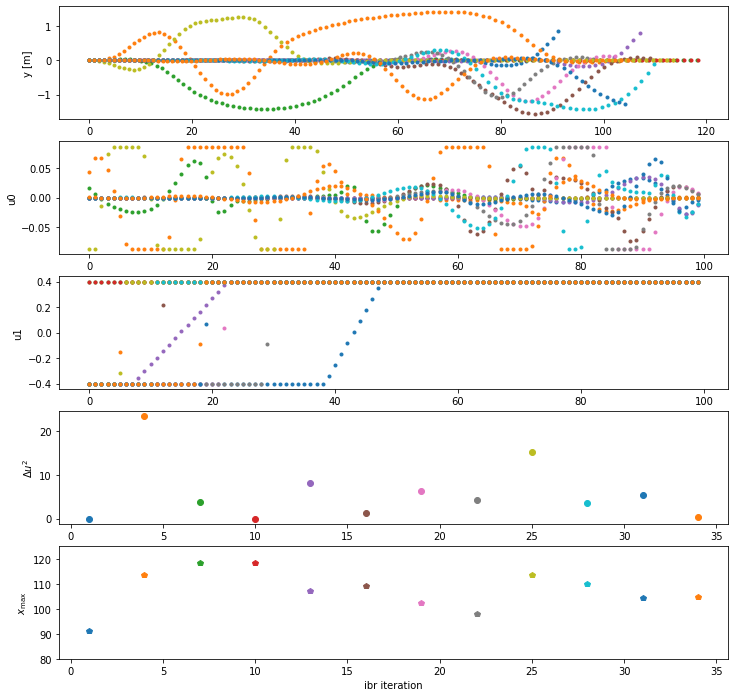

In [16]:
br2 = mpc.IterativeBestResponseMPC(x1_MPC, x2_MPC, amb_MPC )
br2.generate_optimization(N, min_dist, fd, T, x0_2, x0, x0_amb, 2, slack=True)
fig, ax = plt.subplots(5,1)
fig.set_figheight(12)
fig.set_figwidth(12)
ax_t = ax[0]
ax_u0 = ax[1]
ax_u1 = ax[2]
ax_usum = ax[3]
ax_xmax = ax[4]

all_amb = np.zeros((6,101, 12))

initial = True
for ibr_sub_it in range(1, 37):
    if (ibr_sub_it % 3) == 0:
        response_car = "1"
    elif (ibr_sub_it % 3) == 1:
        response_car = "a"
    else:
        response_car = "2"
        
    if response_car == "a":
        ibr_prefix =  '%02d'%ibr_sub_it + "_" + response_car
            
        x1, u1, x1_des, x2, u2, x2_des, xamb, uamb, xamb_des = br2.load_state(folder + ibr_prefix)
        if initial:
            prev_u = uamb
            initial = False
        
        change_in_u = uamb - prev_u
        mag_change_in_u = (change_in_u**2).sum()
        
        ax_t.plot(xamb[0,:],xamb[1,:],'.')
        ax_u0.plot(uamb[0,:],'.')
        ax_u1.plot(uamb[1,:],'.')
        ax_usum.plot(ibr_sub_it, mag_change_in_u,'o')
        ax_xmax.plot(ibr_sub_it, xamb[0,-1],'p')
        prev_u = uamb
        all_amb[:,:,int(ibr_sub_it/3)] = xamb        
        

ax_t.set_ylabel('y [m]')
ax_t.set_xlabel('x [m]')

ax_u0.set_ylabel('u0')
ax_u0.set_xlabel('t [100ms]')

ax_u1.set_ylabel('u1')
ax_u1.set_xlabel('t [100ms]')

ax_usum.set_ylabel(r'$\Delta u^2$')
ax_usum.set_xlabel('ibr iteration')

ax_xmax.set_ylabel(r'$x_{\max}$')
ax_xmax.set_xlabel('ibr iteration')
ax_xmax.set_ylim([80,125])

# plt.show()
fig.savefig(folder  + 'plots.png', dpi=96, transparent=True, bbox_inches="tight",pad_inches=0)

In [10]:
max_x = np.max(all_amb[0,:,:],axis=0)
print("Coop: Final %.02f Mean %.02f Max %.02f, Min %.02f"%(max_x[-1], np.mean(max_x), np.max(max_x), np.min(max_x)))
print(max_x)

Coop: Final 104.68 Mean 107.49 Max 118.34, Min 91.10
[ 91.1  113.55 118.23 118.34 107.04 109.   102.22  98.02 113.59 109.83
 104.26 104.68]


## Decentralized:  IBR to Converge

In [ ]:
car1_v_cost = car1_s_cost
car2_v_cost = car2_s_cost
amb_v_cost = amb_s_cost

In [ ]:
car1_sub_costs = [car1_u_delta_cost, car1_u_v_cost, k_lat1*car1_lat_cost, k_lon1*car1_lon_cost, k_phi1*car1_phi_cost, k_phid1*phid1_cost, q_v*car1_v_cost] 
car1_sub_costs_labels = ['udel1', 'uv1', 'elat1', 'lon1', 'ephi1', 'v1']
plt.bar(range(len(car1_sub_costs)), [sol.value(c) for c in car1_sub_costs])
plt.xticks(range(len(car1_sub_costs)), car1_sub_costs_labels,rotation=45)
plt.title('Car 1')
plt.xlabel("Subcost")
plt.ylabel("Cost Value")
plt.show()

car2_sub_costs = [car2_u_delta_cost, car2_u_v_cost, 10*car2_lat_cost, 10*car2_lon_cost, k_phi2*car2_phi_cost, k_phid2*phid2_cost, q_v*car2_v_cost] 
car2_sub_costs_labels = ['udel2', 'uv2', 'elat2', 'lon2', 'ephi2', 'v2']
plt.bar(range(len(car2_sub_costs)), [sol.value(c) for c in car2_sub_costs])
plt.xticks(range(len(car2_sub_costs)), car2_sub_costs_labels,rotation=45)
plt.title('Car 2')
plt.xlabel("Subcost")
plt.ylabel("Cost Value")
plt.show()

amb_sub_costs = [amb_u_delta_cost, amb_u_v_cost, 10*amb_lat_cost, 10*amb_lon_cost,k_phiamb*amb_phi_cost, k_phidamb*phidamb_cost, q_v*amb_v_cost] 
amb_sub_costs_labels = ['udelA', 'uvA', 'elatA', 'lonA', 'ephiA', 'vA']
plt.bar(range(len(amb_sub_costs)), [sol.value(c) for c in amb_sub_costs])
plt.xticks(range(len(amb_sub_costs)), amb_sub_costs_labels,rotation=45)

plt.title('Amb')
plt.xlabel("Subcost")
plt.ylabel("Cost Value")
plt.show()

all_costs = [0.1*c for c in car1_sub_costs] + [0.1 for c in car2_sub_costs] + [10*c for c in amb_sub_costs]
all_labels = car1_sub_costs_labels + car2_sub_costs_labels + amb_sub_costs_labels
plt.bar(range(len(all_costs)), [sol.value(c) for c in all_costs])
plt.xticks(range(len(all_labels)), all_labels,rotation=90)
plt.title('All Cars')
plt.xlabel("Subcost")
plt.ylabel("Cost Value")

In [ ]:
for BR_iteration in range(20):
    opti2.set_value(x_opt2, sol.value(x_opt))
    opti2.set_value(u_opt2, sol.value(u_opt))

    opti2.set_value(xamb_opt2, sol.value(xamb_opt))
    opti2.set_value(uamb_opt2, sol.value(uamb_opt))

    opti2.set_initial(x2_opt2, sol.value(x2_opt))
    opti2.set_initial(u2_opt2, sol.value(u2_opt))
    sol2 = opti2.solve()

    opti3.set_value(x_opt3, sol2.value(x_opt2))
    opti3.set_value(u_opt3, sol2.value(u_opt2))

    opti3.set_value(x2_opt3, sol2.value(x2_opt2))
    opti3.set_value(u2_opt3, sol2.value(uamb_opt2))

    opti3.set_initial(xamb_opt3, sol2.value(xamb_opt2))
    opti3.set_initial(uamb_opt3, sol2.value(uamb_opt2))    
    sol3 = opti3.solve()
    
    
    opti.set_value(x2_opt, sol3.value(x2_opt3))
    opti.set_value(xamb_opt, sol3.value(xamb_opt3))
    opti.set_value(u2_opt, sol3.value(u2_opt3))
    opti.set_value(uamb_opt, sol3.value(uamb_opt3))

    opti.set_initial(x_opt, sol3.value(x_opt3))
    opti.set_initial(u_opt, sol3.value(u_opt3))    
    sol = opti.solve()
    
    x_warm = sol.value(x_opt)
    u_warm = sol.value(u_opt)
    x2_warm = sol.value(x2_opt)
    u2_warm = sol.value(u2_opt)
    xamb_warm = sol.value(xamb_opt)
    uamb_warm = sol.value(uamb_opt)

#     x_des = sol/

    for k in range(N+1):

        fig, ax = ego_car.get_frame(x_warm[:,k])
        fig, ax = ego_car.get_frame(x2_warm[:,k], ax)
        fig, ax = ego_car.get_frame(xamb_warm[:,k], ax, amb=True)


#         ax.plot(x_des[0,:], x_des[1,:], '--')
#         ax.plot(x2_des[0,:], x2_des[1,:], '--')        

        ax = plt.gca()
        window_width = 24
        window_height = window_width
        xmin, xmax = -1, -1+window_width
        ymin, ymax = -int(window_height/4.0), int(window_height/4.0)
        ax.set_ylim((ymin, ymax))
        ax.set_xlim((xmin, xmax))

        fig.savefig(folder + 'imgs/' '{:03d}.png'.format(k))
        plt.close(fig)         

    vid_fname = folder + '%02d'%BR_iteration + 'car.mp4'
    if os.path.exists(vid_fname):
        os.remove(vid_fname)
    cmd = 'ffmpeg -r 16 -f image2 -i {}imgs/%03d.png -vcodec libx264 -crf 25  -pix_fmt yuv420p {}'.format(folder, vid_fname)
    os.system(cmd)
    print('Saving video to: {}'.format(vid_fname))

In [ ]:
for BR_iteration in range(20):        
    vid_fname = folder + '%02d'%BR_iteration + 'car.mp4'
    
    print('Saving video to: {}'.format(vid_fname))

## Best Response V2

In [ ]:
x1 = sol3.value(x_opt3)
x2 = sol3.value(x2_opt3)
xamb = sol3.value(xamb_opt3)
x_des = sol3.value(xamb_desired_3)

for k in range(N+1):

    fig, ax = ego_car.get_frame(x1[:,k])
    fig, ax = ego_car.get_frame(x2[:,k], ax)
    fig, ax = ego_car.get_frame(xamb[:,k], ax, amb=True)

    
    ax.plot(x_des[0,:], x_des[1,:], '--')
#     ax.plot(x2_des[0,:], x2_des[1,:], '--')        

    ax = plt.gca()
    window_width = 24
    window_height = window_width
    xmin, xmax = -1, -1+window_width
    ymin, ymax = -int(window_height/4.0), int(window_height/4.0)
    ax.set_ylim((ymin, ymax))
    ax.set_xlim((xmin, xmax))

    fig.savefig(folder + 'imgs/' '{:03d}.png'.format(k))
    plt.close(fig)     
    
vid_fname = folder + 'caramb.mp4'
if os.path.exists(vid_fname):
    os.remove(vid_fname)
cmd = 'ffmpeg -r 16 -f image2 -i {}imgs/%03d.png -vcodec libx264 -crf 25  -pix_fmt yuv420p {}'.format(folder, vid_fname)
os.system(cmd)
print('Saving video to: {}'.format(vid_fname))

In [ ]:
car1_sub_costs = [car1_u_delta_cost, car1_u_v_cost, 10*car1_lat_cost, 10*car1_lon_cost, car1_phi_cost, phid1_cost, q_v*car1_v_cost] 
car1_sub_costs_labels = ['udel1', 'uv1', 'elat1', 'lon1', 'ephi1', 'v1']
plt.bar(range(len(car1_sub_costs)), [sol.value(c) for c in car1_sub_costs])
plt.xticks(range(len(car1_sub_costs)), car1_sub_costs_labels,rotation=45)
plt.title('Car 1')
plt.xlabel("Subcost")
plt.ylabel("Cost Value")
plt.show()

car2_sub_costs = [car2_u_delta_cost, car2_u_v_cost, 10*car2_lat_cost, 10*car2_lon_cost, car2_phi_cost, phid2_cost, q_v*car2_v_cost] 
car2_sub_costs_labels = ['udel2', 'uv2', 'elat2', 'lon2', 'ephi2', 'v2']
plt.bar(range(len(car2_sub_costs)), [sol.value(c) for c in car2_sub_costs])
plt.xticks(range(len(car2_sub_costs)), car2_sub_costs_labels,rotation=45)
plt.title('Car 2')
plt.xlabel("Subcost")
plt.ylabel("Cost Value")
plt.show()

amb_sub_costs = [amb_u_delta_cost, amb_u_v_cost, 10*amb_lat_cost, 10*amb_lon_cost, amb_phi_cost, phidamb_cost, q_v*amb_v_cost] 
amb_sub_costs_labels = ['udelA', 'uvA', 'elatA', 'lonA', 'ephiA', 'vA']
plt.bar(range(len(amb_sub_costs)), [sol.value(c) for c in amb_sub_costs])
plt.xticks(range(len(amb_sub_costs)), amb_sub_costs_labels,rotation=45)

plt.title('Amb')
plt.xlabel("Subcost")
plt.ylabel("Cost Value")
plt.show()

all_costs = [0.1*c for c in car1_sub_costs] + [0.1 for c in car2_sub_costs] + [10*c for c in amb_sub_costs]
all_labels = car1_sub_costs_labels + car2_sub_costs_labels + amb_sub_costs_labels
plt.bar(range(len(all_costs)), [sol.value(c) for c in all_costs])
plt.xticks(range(len(all_labels)), all_labels,rotation=90)
plt.title('All Cars')
plt.xlabel("Subcost")
plt.ylabel("Cost Value")

In [ ]:
sol.value(x_opt)[3:5, 10:20]

In [ ]:
dt

In [ ]:
plt.plot(opti.debug.value(x_opt)[4,:],'o',c='b')
plt.plot(opti.debug.value(x2_opt)[4,:],'o',c='g')
plt.plot(opti.debug.value(xamb_opt)[4,:],'o',c='r')
plt.ylabel("Velocity")
plt.show()

In [ ]:
plt.plot(opti.debug.value(u_opt)[1,:],'o',c='b')
plt.plot(opti.debug.value(u2_opt)[1,:],'o',c='g')
plt.plot(opti.debug.value(uamb_opt)[1,:],'o',c='r')
plt.ylabel("Acceleration $\delta V_u$")
plt.show()

In [ ]:
plt.plot([np.sqrt(opti.debug.value(cas.sumsqr(x_opt[0:2,k] - x2_opt[0:2,k]))) for k in range(opti.debug.value(x_opt).shape[1])],'o',c='b')
plt.plot([np.sqrt(opti.debug.value(cas.sumsqr(x_opt[0:2,k] - x2_opt[0:2,k]))) for k in range(opti.debug.value(x_opt).shape[1])],'x',c='g')

plt.plot([np.sqrt(opti.debug.value(cas.sumsqr(x_opt[0:2,k] - xamb_opt[0:2,k]))) for k in range(opti.debug.value(x_opt).shape[1])],'o',c='b')
plt.plot([np.sqrt(opti.debug.value(cas.sumsqr(x_opt[0:2,k] - xamb_opt[0:2,k]))) for k in range(opti.debug.value(x_opt).shape[1])],'x',c='r')

plt.plot([np.sqrt(opti.debug.value(cas.sumsqr(xamb_opt[0:2,k] - x2_opt[0:2,k]))) for k in range(opti.debug.value(x_opt).shape[1])],'o',c='g')
plt.plot([np.sqrt(opti.debug.value(cas.sumsqr(xamb_opt[0:2,k] - x2_opt[0:2,k]))) for k in range(opti.debug.value(x_opt).shape[1])],'x',c='r')

plt.hlines(min_dist,0,50)
plt.ylabel('Intervehicle Distance')
plt.ylim([-.1, 2*min_dist])

In [ ]:
plt.plot([opti.debug.value(slack1) for k in range(opti.debug.value(x_opt).shape[1])],'.',c='b')
plt.plot([opti.debug.value(slack2) for k in range(opti.debug.value(x_opt).shape[1])],'.',c='r')
plt.plot([opti.debug.value(slack3) for k in range(opti.debug.value(x_opt).shape[1])],'.',c='g')


# plt.plot([np.sqrt(opti.debug.value(cas.sumsqr(x_opt[0:2,k] - x2_opt[0:2,k]))) for k in range(opti.debug.value(x_opt).shape[1])],'o',c='b')
# plt.plot([np.sqrt(opti.debug.value(cas.sumsqr(x_opt[0:2,k] - x2_opt[0:2,k]))) for k in range(opti.debug.value(x_opt).shape[1])],'x',c='g')

# plt.plot([np.sqrt(opti.debug.value(cas.sumsqr(x_opt[0:2,k] - xamb_opt[0:2,k]))) for k in range(opti.debug.value(x_opt).shape[1])],'o',c='b')
# plt.plot([np.sqrt(opti.debug.value(cas.sumsqr(x_opt[0:2,k] - xamb_opt[0:2,k]))) for k in range(opti.debug.value(x_opt).shape[1])],'x',c='r')

# plt.plot([np.sqrt(opti.debug.value(cas.sumsqr(xamb_opt[0:2,k] - x2_opt[0:2,k]))) for k in range(opti.debug.value(x_opt).shape[1])],'o',c='g')
# plt.plot([np.sqrt(opti.debug.value(cas.sumsqr(xamb_opt[0:2,k] - x2_opt[0:2,k]))) for k in range(opti.debug.value(x_opt).shape[1])],'x',c='r')

plt.ylabel('slack')
# plt.ylim([.7,.71])

In [ ]:
if not PLOT_LIVE:
    for k in range(N+1):
        
        fig, ax = ego_car.get_frame(x_mpc[:,k])
        fig, ax = ego_car.get_frame(x2_mpc[:,k], ax)
        fig, ax = ego_car.get_frame(xamb_mpc[:,k], ax, amb=True)
        
        ax.plot(x_des[0,:], x_des[1,:], '--')
        ax.plot(x2_des[0,:], x2_des[1,:], '--')        
        
        ax = plt.gca()
        window_width = 24
        window_height = window_width
        xmin, xmax = -1, -1+window_width
        ymin, ymax = -int(window_height/4.0), int(window_height/4.0)
        ax.set_ylim((ymin, ymax))
        ax.set_xlim((xmin, xmax))
        
        fig.savefig(folder + 'imgs/' '{:03d}.png'.format(k))
        plt.close(fig)     